Model has 224k params
Initial training loss: 5.137572288513184, val loss: 5.069249153137207
iter:0 training loss: 5.018100261688232, val loss: 4.9502644538879395
iter:0 training accuracy: 0.0, val accuracy 1.5625

iter:500 training loss: 4.471844673156738, val loss: 4.754312992095947
iter:500 training accuracy: 1.5625, val accuracy 0.0

iter:1000 training loss: 4.092272758483887, val loss: 4.989087104797363
iter:1000 training accuracy: 1.5625, val accuracy 0.0

iter:1500 training loss: 4.0732622146606445, val loss: 5.134264945983887
iter:1500 training accuracy: 0.0, val accuracy 1.5625

iter:2000 training loss: 3.601222038269043, val loss: 4.939342021942139
iter:2000 training accuracy: 1.5625, val accuracy 1.5625

iter:2500 training loss: 3.0118248462677, val loss: 4.49644660949707
iter:2500 training accuracy: 10.9375, val accuracy 3.125

iter:3000 training loss: 2.128889799118042, val loss: 3.88203501701355
iter:3000 training accuracy: 17.1875, val accuracy 4.6875

iter:3500 training 

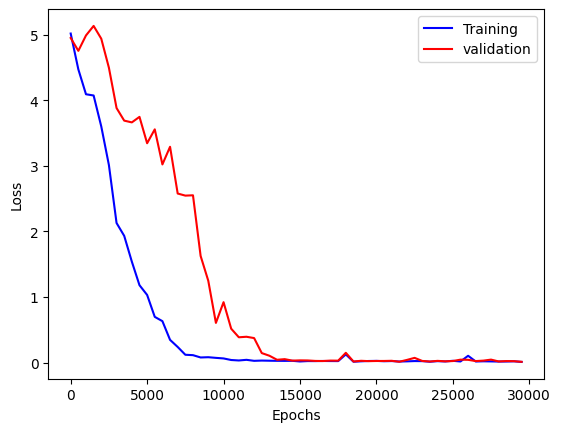

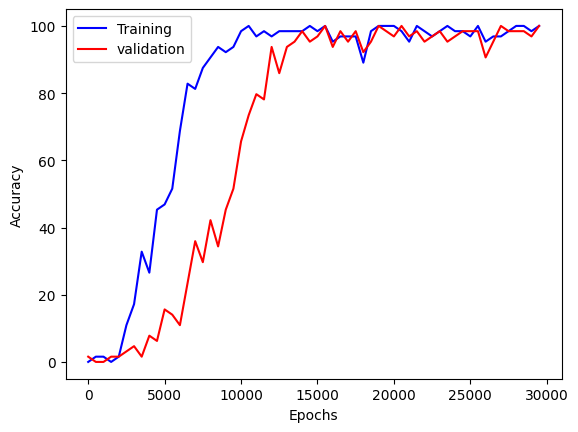

In [23]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import time
import random
import math

PATH = "models/grokking_97.bin"
LOAD_MODEL = False

torch.manual_seed(1)

inf = torch.inf

context_length = 4
P = 97
model_dim = 128 # dimension of the model -> residual stream
n_layers = 1 # no of layers
vocab_size = P + 2
n_heads = 4
learning_rate = 3e-4
max_iters = 30000
eval_iters = 1
batch_size = 64
weight_decay = 1e-3
training_data_percentage = 0.5

special_token_1 = P-1 + 1  # (a%b=c)
special_token_2 = P-1 + 2

total_data = []
for i in range(P):
    for j in range(P):
        total_data.append([i,j])
random.shuffle(total_data)

total_data = torch.tensor(total_data)
total_datapoints = total_data.shape[0]
train_data = total_data[:int(total_datapoints*training_data_percentage)]
val_data = total_data[int(total_datapoints*training_data_percentage):]


def sample_data(split: str = "train"): # With replacement
    if split == "train":
        data = train_data
    else:
        data = val_data
    
    batch_size_ = min(data.shape[0],batch_size)

    X = torch.zeros(batch_size_, context_length).long()
    Y = torch.zeros(batch_size_, context_length).long()
    ix = torch.randint(data.shape[0] - context_length, (batch_size_,))
    batch_index = 0
    for i in ix:
        i = i.item()
        a = data[i][0].item()
        b = data[i][1].item()
        c = (a + b)%P
        x = [a,special_token_1,b,special_token_2]
        y = x[1:] + [c]

        X[batch_index, :len(x)] = torch.tensor(x)
        Y[batch_index, :len(y)] = torch.tensor(y)
        batch_index+=1
    return X, Y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = sample_data(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    
    return out["train"], out['val']


class Layer(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        

class AttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.head_dim = model_dim//n_heads
        self.key = nn.Linear(model_dim, self.head_dim)
        self.query = nn.Linear(model_dim, self.head_dim)
        self.value = nn.Linear(model_dim, self.head_dim)
        self.proj = nn.Linear(self.head_dim, model_dim)
    
    def forward(self, idx):
        key = self.key(idx) # (batch, context_length, head_dim)
        query = self.query(idx)
        value = self.value(idx) # (batch, context_length, head_dim)

        attention = (query@torch.transpose(key,1,2))/(math.sqrt(self.head_dim)) # (batch, context_length, context_length)

        attention = torch.tril(attention)

        attention = attention.masked_fill(attention == 0, -inf)

        attention = F.softmax(attention,-1) # probs along context_length sum to 1

        attention_value = attention@value  # (batch, context_length, head_dim)

        return self.proj(attention_value)  # (batch, context_length, model_dim)
    

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead() for i in range(n_heads)])
    
    def forward(self, idx):
        res_stream = idx
        for head in self.heads:
            idx = idx + head(res_stream)
        return idx
    

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(model_dim, 4*model_dim), nn.ReLU(), nn.Linear(4*model_dim, model_dim))
    
    def forward(self, idx):
        idx = idx + self.layers(idx)
        return idx

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, model_dim)
        self.pos_embedding = nn.Embedding(context_length, model_dim)
        self.attention_layers = nn.ModuleList([MultiHeadAttention() for i in range(n_layers)])
        self.mlp_layers = nn.ModuleList([MLP() for i in range(n_layers)])
        self.unembed_layer = nn.Linear(model_dim,vocab_size)

        self.total_parameters = sum([p.numel() for p in self.parameters()])
        print(f"Model has {self.total_parameters//1000}k params")


    def forward(self, idx, targets = None):
        # idx -> [1,2,0,3..] (batch, context_length)

        # for p in range(idx.shape[0]):
        #     print([decode(idx[p].tolist()), decode(targets[p].tolist())])

        input_sequence_length = idx.shape[-1]

        residual_stream = self.token_embedding(idx)  # (batch, context_length, model_dim)
        residual_stream = residual_stream + self.pos_embedding(torch.tensor([i for i in range(input_sequence_length)])) # Pos embedding will be # (context_length, model_dim)
        
        for i in range(n_layers):
            residual_stream = self.attention_layers[i](residual_stream)
            residual_stream = self.mlp_layers[i](residual_stream)

        residual_stream = self.unembed_layer(residual_stream) # (batch, context_length, vocab_size)
        if targets is None:
            return residual_stream
        
        
        # residual_stream = residual_stream[:,9:,:]
        # targets = targets[:,9:]


        (x,y,z) = residual_stream.shape

        # print(residual_stream.shape, targets.shape)

        residual_stream = residual_stream[:,-1,:]
        targets= targets[:,-1]

        (x,z) = residual_stream.shape

        loss = F.cross_entropy(residual_stream.reshape(x,z), targets.reshape(x))
        return residual_stream, loss
    
model = Transformer()


if LOAD_MODEL:
    model = Transformer()
    model.load_state_dict(torch.load(PATH))
    model.eval()

train_loss,val_loss = estimate_loss()
print(f"Initial training loss: {train_loss}, val loss: {val_loss}")

loss_value = []
val_loss_value = []
accuracy_value = []
val_accuracy_value = []
iters = []
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay= weight_decay)
step_value = min(max_iters/50, 500)
start_time = time.time()
for iter in range(max_iters):
    X,Y= sample_data() # (B, context_length)
    logits, loss = model(X, Y)  # (B, context_length, vocab_size)
    if iter%step_value ==0:
        train_loss,val_loss = estimate_loss()
        iters.append(iter)

        # train_loss,val_loss = math.log(train_loss), math.log(val_loss)

        loss_value.append(train_loss)
        val_loss_value.append(val_loss)

        train_accuracy, val_accuracy = get_accuracy('train'), get_accuracy('val')
        accuracy_value.append(train_accuracy)
        val_accuracy_value.append(val_accuracy)

        print(f"iter:{iter} training loss: {train_loss}, val loss: {val_loss}")
        print(f"iter:{iter} training accuracy: {train_accuracy}, val accuracy {val_accuracy}")
        print()

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    # if val_accuracy >= 99.9 and train_accuracy >=99.9:
    #     break
    
end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(iters,accuracy_value, color='blue', label="Training")
plt.plot(iters, val_accuracy_value, "red", label = "validation")
plt.legend()
plt.show()





In [16]:
def inference(input: list[int]):
    input_tokens = torch.tensor(input)
    
    now = model(input_tokens.unsqueeze(0))[0][-1]
    now = F.softmax(now, dim= 0)
    try:
        token = torch.multinomial(now,1).item()
    except:
         print(now)
         print(model(input_tokens.unsqueeze(0))[0][-1])
         print(1/0)
    input_tokens = torch.tensor(input_tokens.tolist() + [token])
    return token


def get_accuracy(split: str = "train"):
    true = 0
    tot = 0

    X,Y = sample_data(split)
    size = X.shape[0]



    for i in range(size):
            ans = inference(X[i].tolist())
            c = Y[i][-1].item()
            #print(ans,c)

            tot+=1
            if c == ans:
                true+=1
    return (true*100/tot)

print(get_accuracy("train"))
print(get_accuracy("val"))


98.4375
96.875


In [24]:
PATH = "models/grokking_97.bin"
torch.save(model.state_dict(), PATH)


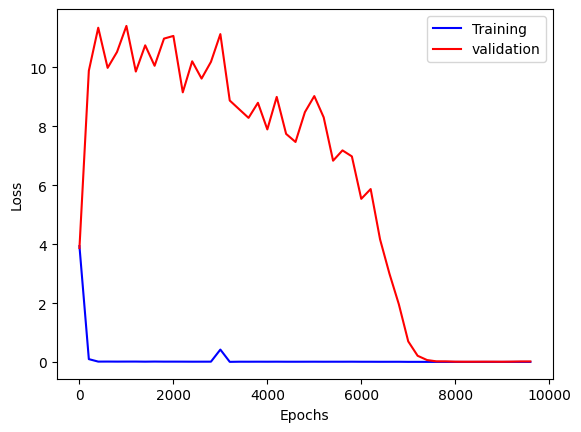

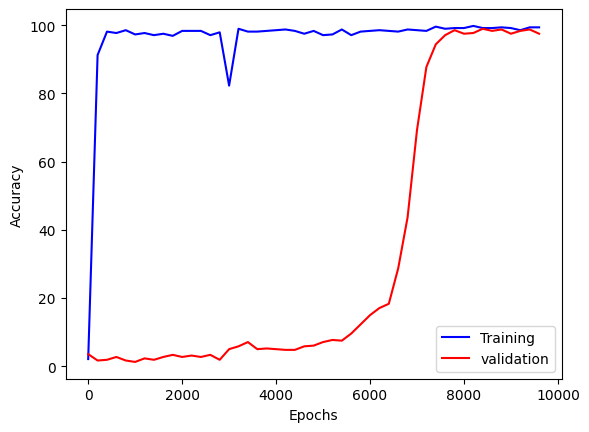

In [42]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(iters,accuracy_value, color='blue', label="Training")
plt.plot(iters, val_accuracy_value, "red", label = "validation")
plt.legend()
plt.show()